<div class="notebook-quickstart">
<h3>Quickstart</h3>
To run the code below:
<ol>
<li>Click on the cell to select it.</li>
<li>Press <code>SHIFT+ENTER</code> on your keyboard or press the play button
   (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above</li>
</ol>
Feel free to create new cells using the plus button
(<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or pressing <code>SHIFT+ENTER</code> while this cell
is selected.
</div>

"Scheduling": mechanism to determine the order of operations during a simulation

In this notebook we will look at its importance for:
* recording values with a `StateMonitor`

You can also watch the <a href="https://youtu.be/ib0UMU-H6eY"><i class="fab fa-youtube"></i>&nbsp; screencast video on Youtube</a>.
<!-- TEASER_END -->

In [1]:
from brian2 import *
from brian2tools import brian_plot
%matplotlib notebook
prefs.codegen.target = 'numpy'

The following example is a leaky integrate-and-fire neuron with a constant current input. As soon as the membrane potential crosses the threshold of -50mV, a spike is emitted and the membrane potential reset to -70mV.

<IPython.core.display.Javascript object>


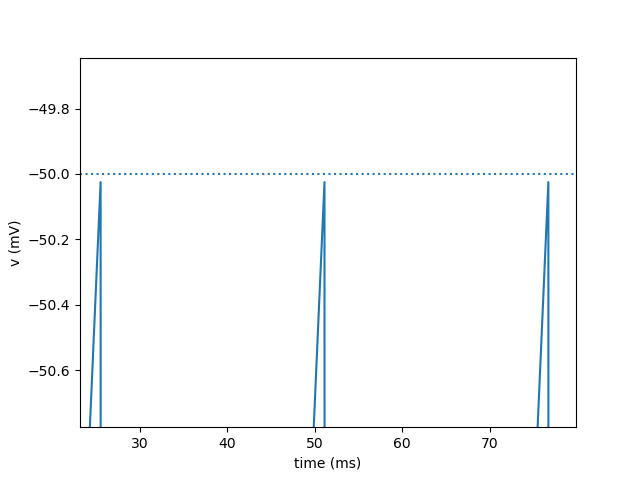

In [2]:
start_scope()
C_m = 1*nF
g_L = 20*nS
E_L = -70*mV
I_ext = 1*nA
group = NeuronGroup(1, '''dv/dt = (g_L*(E_L -v) + I_ext)/C_m : volt''',
                   threshold='v>-50*mV', reset='v=E_L',
                   method='exact')
group.v = E_L

mon = StateMonitor(group, 'v', record=0)

run(100*ms)

fig, ax = plt.subplots()
brian_plot(mon, axes=ax)
ax.axhline(-50, linestyle=':');

If you zoom into the plot above, you see that the membrane potential never seems to cross the threshold!
We can also see this by analyzing the recorded membrane potential values:

In [3]:
mon.v[0].max()

-50.02477894 * mvolt

The reason for this becomes clear when we look into Brian's scheduling in more detail. Brian comes with a useful function `scheduling_summary`, that displays the scheduling information for the current network:

In [4]:
scheduling_summary()

object                  |           part of           |       Clock dt       |    when    | order | active
----------------------------------------+-----------------------------+----------------------+------------+-------+-------
statemonitor (StateMonitor)             | statemonitor (StateMonitor) | 100. us (every step) | start      |     0 |  yes  
neurongroup_stateupdater (StateUpdater) | neurongroup (NeuronGroup)   | 100. us (every step) | groups     |     0 |  yes  
neurongroup_thresholder (Thresholder)   | neurongroup (NeuronGroup)   | 100. us (every step) | thresholds |     0 |  yes  
neurongroup_resetter (Resetter)         | neurongroup (NeuronGroup)   | 100. us (every step) | resets     |     0 |  yes

As you can see above, the first thing that gets executed during a time step is the `StateMonitor`, followed by the state update step (the numerical integration of the differential equations), the threshold check, and finally the reset. Now the previous observation makes sense. In a time step where the threshold is crossed, the following things happen:
1. The membrane potential gets recorded (it is still below the threshold)
2. The state update step updates the membrane potential, it is now above the threshold
3. The thresholder compares the membrane potential to the threshold and signals a spike
4. The resetter resets the membrane potential

The `StateMonitor` therefore never records a membrane potential that is above the threshold.

How is the order of operations determined? Each object has a `when` and and `order` attribute. The basic execution slot is defined by the `when` attribute, the `order` attribute is only used when there is more than one object in the same slot.

The slots and their order are given in the `schedule` attribute of the `Network` object (here we use `magic_network`, because we haven't constructed a `Network` object ourselves):

In [5]:
magic_network.schedule

['start', 'groups', 'thresholds', 'synapses', 'resets', 'end']

In addition to the listed slots, there are `before_...` and `after_...` for each of the names, just before and after the corresponding slots. If we are interested in recording the membrane potential before the threshold is checked, we can therefore use `before_thresholds`:

<IPython.core.display.Javascript object>


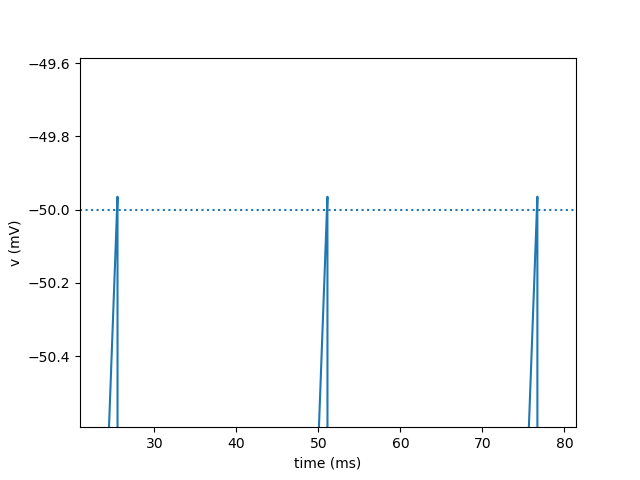

In [6]:
start_scope()
C_m = 1*nF
g_L = 20*nS
E_L = -70*mV
I_ext = 1*nA
group = NeuronGroup(1, '''dv/dt = (g_L*(E_L -v) + I_ext)/C_m : volt''',
                   threshold='v>-50*mV', reset='v=E_L',
                   method='exact')
group.v = E_L

mon = StateMonitor(group, 'v', record=0, when='before_thresholds')  # <-- change here

run(100*ms)

fig, ax = plt.subplots()
brian_plot(mon, axes=ax)
ax.axhline(-50, linestyle=':');

Now, the membrane potential that gets recorded by the `StateMonitor` does indeed cross the threshold, as you can confirm by zooming into the above plot or by checking the recorded values:

In [7]:
mon.v[0].max()

-49.96478939 * mvolt

We can easily verify that this change is due to the change in scheduling:

In [8]:
scheduling_summary()

object                   |            part of            |       Clock dt       |       when        | order | active
------------------------------------------+-------------------------------+----------------------+-------------------+-------+-------
neurongroup_1_stateupdater (StateUpdater) | neurongroup_1 (NeuronGroup)   | 100. us (every step) | groups            |     0 |  yes  
statemonitor_1 (StateMonitor)             | statemonitor_1 (StateMonitor) | 100. us (every step) | before_thresholds |     0 |  yes  
neurongroup_1_thresholder (Thresholder)   | neurongroup_1 (NeuronGroup)   | 100. us (every step) | thresholds        |     0 |  yes  
neurongroup_1_resetter (Resetter)         | neurongroup_1 (NeuronGroup)   | 100. us (every step) | resets            |     0 |  yes

As you can see above, the `StateMonitor` now records its values *after* the state update step and no longer before.

For more information on this topic, have a look at Brian's [<i class="fas fa-book"></i>&nbsp;documentation](https://brian2.readthedocs.io/en/stable/user/running.html#scheduling)